In [19]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [20]:
import pandas as pd

# load education data
data_clean = pd.read_csv('fr.openfoodfacts.org.products.clean.csv', sep=',', index_col=[0])

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,4,6,9,10,11,12,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,34,35,36,37,43,44,48,49,50,51) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# French data selection

In [21]:
data_france = data_clean[data_clean["countries"].str.contains("france|en:fr", na=False, case=False)]

print("articles number in french database : ", len(data_france))
print("columns number in french database : ", len(data_france.columns))

data_france.to_csv("fr.openfoodfacts.org.products.france.csv")

articles number in french database :  98103
columns number in french database :  72


# Nutriscore data process

## Select and clean to process nutriscore
Nutriscore is process :
- using 8 nutritional parameters : 
    - energy_100g, 
    - fat_100g
    - saturated-fat_100g
    - sugars_100g
    - fiber_100g
    - proteins_100g
    - sodium_100
    - fruits-vegetables-nuts_100g
- knowing if the product is beverage or not
- knowing if the product is beverage, if it is mineral water
In this part, we recover all this data

In [22]:
# 7 parameters are already there and sufficiently filled. 
# For the articles with not enough data, remove them.
nutrition_columns = ["energy_100g", 'fat_100g', 'saturated-fat_100g', 
                     'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g']

data = data_france.copy()

fill_factor = 0.5

data = data[data[nutrition_columns].apply(
            lambda row: pd.notnull(row).sum() > len(row) * fill_factor, axis=1)]

print("number of articles before removing: ", len(data_france))
print("number of articles after removing: ", len(data))

data.count().to_csv("test.csv")

number of articles before removing:  98103
number of articles after removing:  62667


## Nutriscore data filling

In [23]:
# For these 7 parameters, use iterative imputer of scikit learn to fill the empty data
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

data_nutri = data[nutrition_columns]

# Create the learner
imp = IterativeImputer(max_iter=5, random_state=0, 
                       skip_complete = True, sample_posterior = True,
                      missing_values = np.nan, min_value = 0,
                      max_value = 1000)
# Put original data to train it
imp.fit(data_nutri)

# Use the trained learner to predicate the empty data
data_nutri[data_nutri.isna().any(axis=1)] = imp.transform(
                                    data_nutri[data_nutri.isna().any(axis=1)])

/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1090/1329846157.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nutri[data_nutri.isna().any(axis=1)] = imp.transform(
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pand

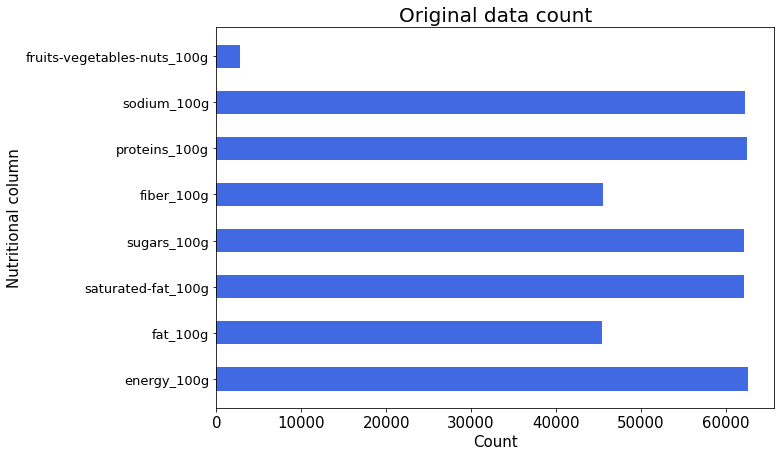

In [24]:
import matplotlib.pyplot as plt
# Display 
fig, ax = plt.subplots(figsize=(10,7))
N = len(nutrition_columns+["fruits-vegetables-nuts_100g"])
width = 0.5 

ind = np.arange(N)    # the x locations for the groups
p1 = plt.barh(ind, data[nutrition_columns+["fruits-vegetables-nuts_100g"]].count(), width, color='royalblue')

plt.ylabel('Nutritional column', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.title('Original data count', fontsize=20)
plt.yticks(ind, nutrition_columns+["fruits-vegetables-nuts_100g"], fontsize=13)
plt.xticks(fontsize=15)
plt.show()

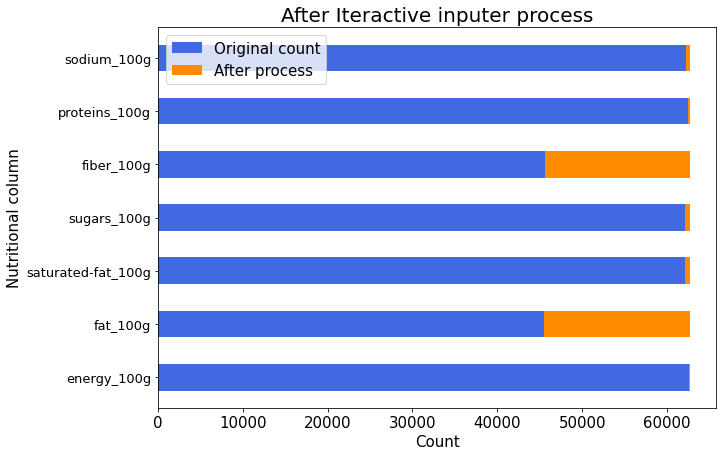

In [25]:
# Display 
fig, ax = plt.subplots(figsize=(10,7))
N = len(nutrition_columns)
width = 0.5 

ind = np.arange(N)    # the x locations for the groups
p1 = plt.barh(ind, data[nutrition_columns].count(), width, color='royalblue')
p2 = plt.barh(ind, data_nutri.count() - data[nutrition_columns].count(),
              width, color='darkorange', left=data[nutrition_columns].count())

plt.ylabel('Nutritional column', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.title('After Iteractive inputer process', fontsize=20)
plt.yticks(ind, nutrition_columns, fontsize=13)
plt.xticks(fontsize=15)
plt.legend((p1[0], p2[0]), ('Original count', 'After process'), fontsize=15)

plt.show()

In [26]:
data[nutrition_columns] = data_nutri

## Add and filled remaining columns

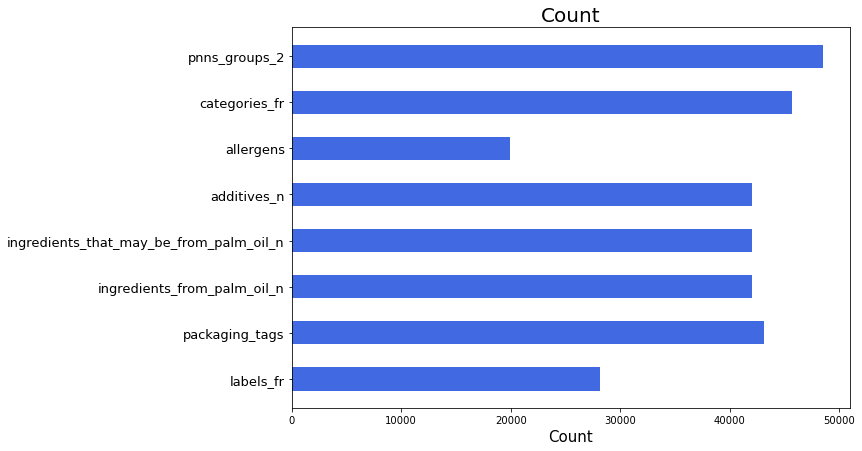

In [27]:
columns = ["labels_fr", "packaging_tags", "ingredients_from_palm_oil_n", 
"ingredients_that_may_be_from_palm_oil_n", "additives_n", "allergens", 
"categories_fr", "pnns_groups_2"]

import matplotlib.pyplot as plt
# Display 
fig, ax = plt.subplots(figsize=(10,7))
N = len(columns)
width = 0.5 
data.count().to_csv("test.csv")
ind = np.arange(N)    # the x locations for the groups
p1 = plt.barh(ind, data[columns].count(), width, color='royalblue')

plt.xlabel('Count', fontsize=15)
plt.title('Count', fontsize=20)
plt.yticks(ind, columns, fontsize=13)
plt.show()

### Fill fruits-vegetables-nuts column

In [28]:
def is_word_in(x, words_list):
    if pd.notnull(x) and isinstance(x, str):
        return any(item for item in words_list if item in x)
    return False

In [29]:
fln_list = ["Légumes frais", "Fruits", "Fruits à coques", "Jus de fruits",
            "Fruits secs", "Nectars de fruits", "Huiles", "Huiles d'olive",
            "Jus de pomme", "Tomates", "Olives vertes", "Jus d'orange",
            "Jus de pamplemousse"]

is_fln = data["main_category_fr"].apply(lambda x: is_word_in(x, fln_list))

print("Value number before adding new 'fruit, vegetables and nuts products' : ", \
      (data['fruits-vegetables-nuts_100g'] > 90).sum())

data.loc[is_fln, 'fruits-vegetables-nuts_100g'] = 100.0

print("Value number after adding new 'fruit, vegetables and nuts products' : ", \
      (data['fruits-vegetables-nuts_100g'] > 90.0).sum())

Value number before adding new 'fruit, vegetables and nuts products' :  217
Value number after adding new 'fruit, vegetables and nuts products' :  3340


### Test knn to fill fruits-vegetables-nuts column

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import random

def train_with_knn(X, y, iterations_number):
    model = KNeighborsClassifier(n_neighbors=2)

    y_old = y
    y_new_global = len(X) * [False]
    print('is in group count begin :', y.sum())
    cpt = 0
    while cpt < iterations_number:
        is_group = X[y_old == True]
        is_not_group = X[y_old == False]
    
        # Get random articles with no fln
        rand_list = random.sample(range(0, len(is_not_group)), int(0.5*len(is_not_group)))
        is_not_group_sample = is_not_group.iloc[rand_list]
        
        # Concatenate train set (no fln + fln)
        global_sample = pd.concat([is_group, is_not_group_sample], axis=0, copy=False)   
        
        # Create y corresponding
        y_train = len(is_group) * [True] + len(is_not_group_sample) * [False]
        
        # Train the model using the training sets
        model.fit(global_sample, y_train)
    
        #Predict Output
        y_new = model.predict(X)
        print('new pred is in group nb :', y_new.sum())

        if pd.Series(y_old).equals(y_new):
            print("is_equal")
            break
        
        # Gather new predictions each iteration
        y_new_global = y_new_global|y_new
        
        # Gather new and old predictions for next iteration
        y_old = y_old|y_new
        print('new and old predication nb :', y_old.sum())
        cpt = cpt + 1

    return y_new_global

In [41]:
# Test knn algorithm to predict 'fruits vegetables nuts' products
y = train_with_knn(data[nutrition_columns], data['fruits-vegetables-nuts_100g'] > 90.0, 1)    

# Display new products that is predicted having 'fruits vegetables nuts'
df = data["product_name"][y]

print(df.head(30))

is in group count begin : 3340
new pred is in group nb : 2649
new and old predication nb : 3728
214365                           Jus d'orange des tropiques
214363                                      Nectar Tropical
212237                         Pur jus de pamplemousse rose
204241                 Pruneaux d'Agen très gros dénoyautés
217536                                               Isio 4
212510                           Huile d'Olive vierge extra
246215    Energy orange, mangue, acérola,guarana pasteurisé
212016                                   Huile de Tournesol
222005    Nectar fruits de la passion à base de jus conc...
194840                                Le Fruit - Multifruit
192499                                  Moutarde provençale
220342                                    Formule Equilibre
220341                                        Formule Eclat
278107                    Pure Premium, Ananas Citron Vert 
191468                  Essentiels Multivitamines 12 fruits
2376

**CONCLUSION : 
Prediction give good predictions but make some errors and add some beverages that is not composed by fruits-vegetables-nuts products, e.g 'Coca Cola sans caféine'**

### Fill is_water and is_berverage column

In [43]:
def is_word_in(x, words_list):
    if pd.notnull(x) and isinstance(x, str):
        return any(item for item in words_list if item in x)
    return 

# Get products that is mineral water from categories column
water_list = ["Eaux minérales"]
data["is_water"] = data["categories_fr"].apply(
    lambda x: is_word_in(x, water_list))

beverage_list = ["Beverages"]
data["is_beverage"] = data["pnns_groups_1"].apply(
    lambda x: is_word_in(x, beverage_list))

print("New productions considered as water :", (data['is_water']).sum())
print("New productions considered as beverage :", (data['is_beverage']).sum())

New productions considered as water : 51
New productions considered as beverage : 4584


#  Create new eco labeled columns

## Simplify palm oil column by creating one palm oil number column

In [85]:
# Create palm oil ingredients number column
data["palm_oil_n"] = data["ingredients_from_palm_oil_n"] + \
                     data["ingredients_that_may_be_from_palm_oil_n"]


print("ingredients from palm oil number :", \
      (data["ingredients_from_palm_oil_n"][~data["ingredients_from_palm_oil_n"].isna()]!=0).sum())

print("ingredients that may be from palm oil number :", \
      (data["ingredients_that_may_be_from_palm_oil_n"][~data["ingredients_that_may_be_from_palm_oil_n"].isna()]!=0).sum())

print("palm oil values number :", \
      (data["palm_oil_n"][~data["palm_oil_n"].isna()]!=0).sum())

ingredients from palm oil number : 3346
ingredients that may be from palm oil number : 5478
palm oil values number : 7765
palm oil values number : 42023


## Create one allergens number column

In [86]:
# Recover allergens column
def split_and_unified(case):
    if pd.notnull(case) and isinstance(case, str):
        return len(set({v.strip().casefold(): v.strip() \
                                            for v in case.split(',')}.values()))

# Create allergens number column and count unique word in allergens
data["allergens_n"] = data["allergens"].apply(lambda x: split_and_unified(x))

print("allergens values nb :", \
      (data["allergens_n"][~data["allergens_n"].isna()]!=0).sum())

allergens values nb : 19945


## Create one biological label column

In [87]:
# Create eco label column

data_label = data[~data["labels_fr"].isnull()]
data["is_label_bio"] = ~data_label["labels_fr"].str.contains("biot", na=True, case=False) & \
                        data_label["labels_fr"].str.contains("bio", na=True, case=False)

print("label bio values nb :", data["is_label_bio"].sum())

label bio values nb : 9451


## Create one packaging score column

In [88]:
# First create one list of all the different words in packaging_tags column
import itertools
import re
from collections import Counter

package_data = data[pd.notnull(data["packaging_tags"])]["packaging_tags"]
package_data = package_data.apply(lambda x: re.split(',|-|:', x))
print(itertools.chain.from_iterable(package_data.to_list()))
package_words_list = list(itertools.chain.from_iterable(package_data.to_list()))

package_words_list = [v.strip() for v in package_words_list]
words_counts = Counter(package_words_list)

words_counts_df = pd.DataFrame.from_dict(words_counts, 
                                       columns = ["occurrence"], 
                                       orient='index')
words_counts_df.to_csv("packaging_word_list.csv")

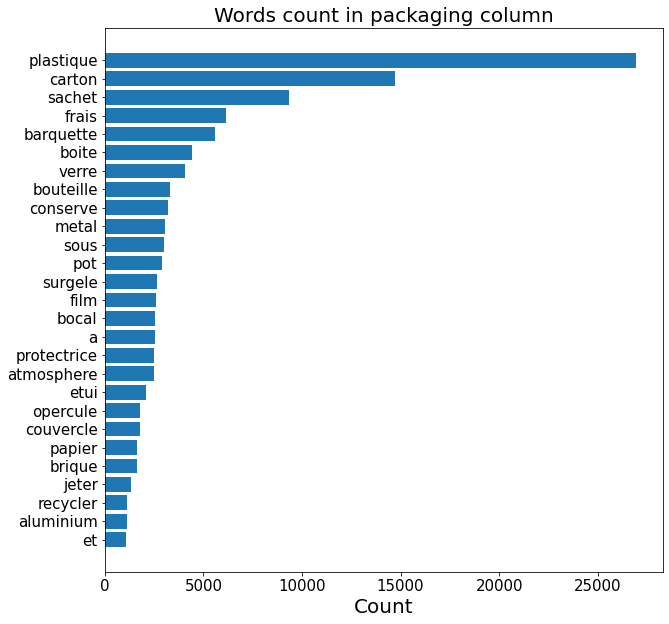

In [89]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))

# Reduce words_counts index to display
words_counts = {k: v for k, v in words_counts.items() if v > 1000}
words_counts =  {k: v for k, v in sorted(words_counts.items(), key=lambda item: item[1])}

labels, values = zip(*words_counts.items())

# Display 
ax.barh(labels, values, align='center')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Count', fontsize=20)
ax.set_title('Words count in packaging column', fontdict = {
                             'fontsize': 20,
                            })
plt.sca(ax)
plt.yticks(size=15)
plt.xticks(size=15)
plt.show()

In [90]:
# After having arrange the words of packaging_tags,
# We decide to classify the words in 5 groups : plastique, carton, metal, verre, bois
# We classify, directly in the csv file, the words we can according to these 5 groups
# E.g the word 'conserve' is classified in 'metal' group
# We then reload the packaging words table
words_classified_df = pd.read_csv('packaging_word_list_classified.csv',
                                  index_col=[0], sep=';')
words_classified_df.reset_index(level=0, inplace=True)
# Kepp only words that have an associated group
words_classified_df = words_classified_df[pd.notnull(words_classified_df["equivalent to"])]
# Transform dataframe in dict
words_classified_dict = dict(zip(words_classified_df["index"], words_classified_df["equivalent to"]))

# Create eco packaging graduation dict
# (source : https://id-champagne-ardenne.fr/quel-est-lemballage-alimentaire-le-plus-ecologique)
carbon_coef = {
    'plastique': 0,
    'carton': 1,
    'metal': 2,
    'verre': 3,
    'bois': 4
}

dat = pd.DataFrame.from_dict(carbon_coef, orient='index')
dat.to_csv("test.csv")

# Create a dict that map words in pack_words list to carbon coef 
pack_coef = {item[0] : carbon_coef[item[1]] for item in words_classified_dict.items()}

def map_pack_to_coef(string):
    if pd.notnull(string) and isinstance(string, str):
        liste = re.split(',|-|:', string)
        liste_coef = [pack_coef[x] for x in liste if x in pack_coef]
        if len(liste_coef):
            return min(liste_coef)

# Map packaging_tags column using precedent dict and create new column 
# containing the carbon coef for each articles having packaging_tags
data['packaging_coef'] = data['packaging_tags']\
                            .apply(lambda string: map_pack_to_coef(string))


print("origin packaging tags nb :", (pd.notnull(data["packaging_tags"])).sum())
print("resulting packaging values nb :", (pd.notnull(data["packaging_coef"])).sum())

origin packaging tags nb : 43144
resulting packaging values nb : 41504


# Create database with selected data

In [93]:
txt_columns = ["product_name"]

cat_columns = [
    "main_category_fr", "main_category",
    "categories_fr", "categories", "categories_tags", 
    "pnns_groups_1", "pnns_groups_2",
    "countries", "brands", 
]

nutrition_columns = [
    "nutrition_grade_fr", 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
]

quantity_columns = [
    "is_water",
    "is_beverage",
    "fat_100g", "saturated-fat_100g", "fruits-vegetables-nuts_100g",
    "sugars_100g", "sodium_100g", "fiber_100g",
    "energy_100g", "proteins_100g",
]

created_columns = [
    "palm_oil_n", 
    "allergens_n", 
    "additives_n",
    "is_label_bio", 
    "packaging_coef",
]

data_selected = data[txt_columns + cat_columns + quantity_columns + nutrition_columns + created_columns]

data_selected.to_csv("fr.openfoodfacts.org.products.selected.csv")

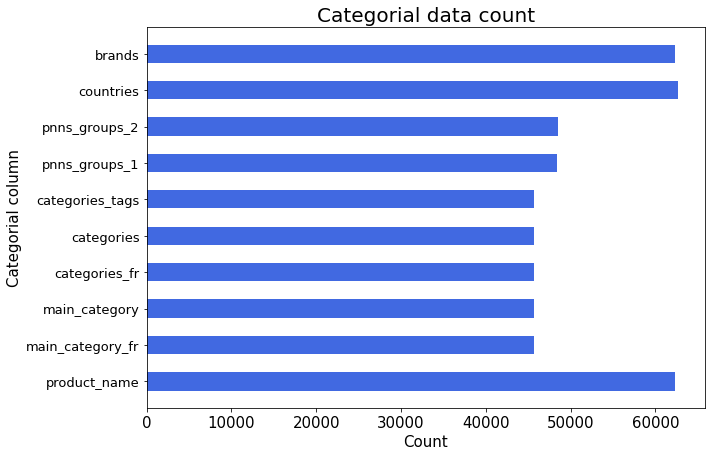

In [94]:
# Display 
fig, ax = plt.subplots(figsize=(10,7))
N = len(txt_columns+cat_columns)
width = 0.5 

ind = np.arange(N)    # the x locations for the groups
p1 = plt.barh(ind, data_selected[txt_columns+cat_columns].count(), width, color='royalblue')

plt.ylabel('Categorial column', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.title('Categorial data count', fontsize=20)
plt.yticks(ind, txt_columns+cat_columns, fontsize=13)
plt.xticks(fontsize=15)
plt.show()

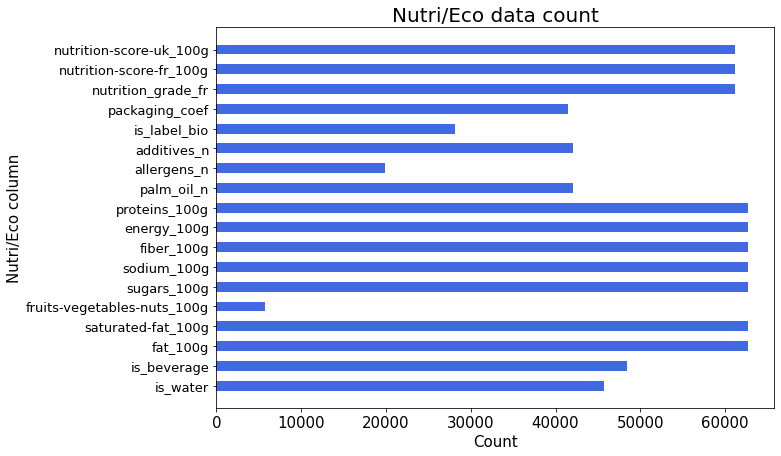

In [95]:
# Display 
fig, ax = plt.subplots(figsize=(10,7))
N = len(quantity_columns+created_columns+nutrition_columns)
width = 0.5 

ind = np.arange(N)    # the x locations for the groups
p1 = plt.barh(ind, data_selected[quantity_columns+created_columns+nutrition_columns].count(), width, color='royalblue')

plt.ylabel('Nutri/Eco column', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.title('Nutri/Eco data count', fontsize=20)
plt.yticks(ind, quantity_columns+created_columns+nutrition_columns, fontsize=13)
plt.xticks(fontsize=15)
plt.show()